In [1]:
import pyedflib
import numpy as np
import os
import connectivipy as cp
from connectivipy import mvar_gen
import networkx as nx 
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import igraph as ig
from igraph import Graph

In [2]:
current_dir = os.getcwd()
print(current_dir)
subject = "S079"
sub_edf = "S079R01.edf"
file_name = os.path.join(current_dir, subject, sub_edf)
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
#eo stands for eyes open, it is the numpy array corresponding to the first run
eo = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    eo[i, :] = f.readSignal(i)
f.close()

/home/ivan/Desktop/AIRO2ndyear/BIO/BigBrain


In [3]:
print("\nlibrary version: %s" % pyedflib.version.version)
print("\ngeneral header:\n")
print("edfsignals: %i" % f.signals_in_file)
print("file duration: %i seconds" % f.file_duration)
print("startdate: %i-%i-%i" % (f.getStartdatetime().day,f.getStartdatetime().month,f.getStartdatetime().year))
print("starttime: %i:%02i:%02i" % (f.getStartdatetime().hour,f.getStartdatetime().minute,f.getStartdatetime().second))
print("patientcode: %s" % f.getPatientCode())
print("gender: %s" % f.getGender())
print("birthdate: %s" % f.getBirthdate())
print("patient_name: %s" % f.getPatientName())
print("patient_additional: %s" % f.getPatientAdditional())
print("admincode: %s" % f.getAdmincode())
print("technician: %s" % f.getTechnician())
print("equipment: %s" % f.getEquipment())
print("recording_additional: %s" % f.getRecordingAdditional())
print("datarecord duration: %f seconds" % f.getFileDuration())
print("number of datarecords in the file: %i" % f.datarecords_in_file)
print("number of annotations in the file: %i" % f.annotations_in_file)


library version: 0.1.15

general header:

edfsignals: 64
file duration: 61 seconds
startdate: 12-8-2009
starttime: 16:15:00
patientcode: 
gender: 
birthdate: 
patient_name: X
patient_additional: 
admincode: 
technician: 
equipment: BCI2000
recording_additional: 
datarecord duration: 61.000000 seconds
number of datarecords in the file: 61
number of annotations in the file: 1


In [4]:
#fitting in the model for eo with method yule-walker
model_eo = cp.Mvar().fit(eo, method = "yw")

#compute PDC
eo_pdc=cp.conn.pdc_fun(model_eo[0],model_eo[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(eo_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2
n = eo_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-eo_pdc, axis = None)[num_edges+1]

#adj_matrix
eo_adj = (eo_pdc > threshold).astype(int)

###### 1.1 
Estimate functional brain connectivity among 64 channels using one of the
MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF). Select
one relevant frequency value. Apply a threshold so that the resulting binary connectivity
matrices have network density equal to 20%. Create a graphical representation of the binary
adjacency matrix.

{0: 'Fc5.', 1: 'Fc3.', 2: 'Fc1.', 3: 'Fcz.', 4: 'Fc2.', 5: 'Fc4.', 6: 'Fc6.', 7: 'C5..', 8: 'C3..', 9: 'C1..', 10: 'Cz..', 11: 'C2..', 12: 'C4..', 13: 'C6..', 14: 'Cp5.', 15: 'Cp3.', 16: 'Cp1.', 17: 'Cpz.', 18: 'Cp2.', 19: 'Cp4.', 20: 'Cp6.', 21: 'Fp1.', 22: 'Fpz.', 23: 'Fp2.', 24: 'Af7.', 25: 'Af3.', 26: 'Afz.', 27: 'Af4.', 28: 'Af8.', 29: 'F7..', 30: 'F5..', 31: 'F3..', 32: 'F1..', 33: 'Fz..', 34: 'F2..', 35: 'F4..', 36: 'F6..', 37: 'F8..', 38: 'Ft7.', 39: 'Ft8.', 40: 'T7..', 41: 'T8..', 42: 'T9..', 43: 'T10.', 44: 'Tp7.', 45: 'Tp8.', 46: 'P7..', 47: 'P5..', 48: 'P3..', 49: 'P1..', 50: 'Pz..', 51: 'P2..', 52: 'P4..', 53: 'P6..', 54: 'P8..', 55: 'Po7.', 56: 'Po3.', 57: 'Poz.', 58: 'Po4.', 59: 'Po8.', 60: 'O1..', 61: 'Oz..', 62: 'O2..', 63: 'Iz..'}


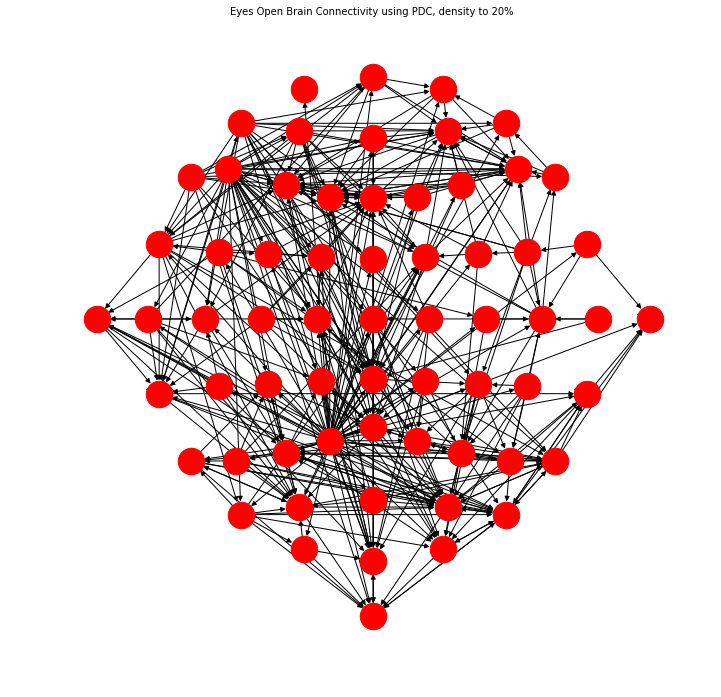

In [5]:
position=pd.read_csv('channel_locations.txt', sep='\s+')

G_open = nx.DiGraph(eo_adj)
#rename labels
labels={}
for i in range(0, 64):
    labels[i]=position['label'][i]
print(labels)
G_open= nx.relabel_nodes(G_open,labels) 
#create a pos dictionary to pass the position to the nodes of our graph
pos={}
for i in range(0, 64):
    pos[position['label'][i]]=[position['x'][i],position['y'][i]]

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Eyes Open Brain Connectivity using PDC, density to 20% ', fontsize=10)

nx.draw(G_open, pos, node_size=700)
nx.draw_networkx_labels(G_open, pos=pos, font_color='red')
#nx.draw(G_open, with_labels=True)

plt.savefig("PDC_eyes_open.png", format="PNG")
plt.show()

In [6]:
current_dir = os.getcwd()
print(current_dir)
subject = "S079"
sub_edf = "S079R02.edf"
file_name = os.path.join(current_dir, subject, sub_edf)
f = pyedflib.EdfReader(file_name)
n = f.signals_in_file
signal_labels = f.getSignalLabels()
#ec stands for eyes closed, it is the numpy array corresponding to the second run
ec = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    ec[i, :] = f.readSignal(i)


#fitting in the model for ec with method yule-walker
model_ec = cp.Mvar().fit(ec, method = "yw")

#compute PDC
ec_pdc=cp.conn.pdc_fun(model_ec[0],model_ec[1],fs = 160, resolution = 100)[10,:,:]
np.fill_diagonal(ec_pdc,0)

#find our threshold
density=0.2 #set the density to 0.2
n = ec_pdc.shape[0]  
num_edges = int((density*n*(n-1))/2)    
threshold = -np.sort(-ec_pdc, axis = None)[num_edges+1]

#adj_matrix
ec_adj = (ec_pdc > threshold).astype(int)

/home/ivan/Desktop/AIRO2ndyear/BIO/BigBrain


In [7]:
#Create graphical representation of the binary adjacency matrix

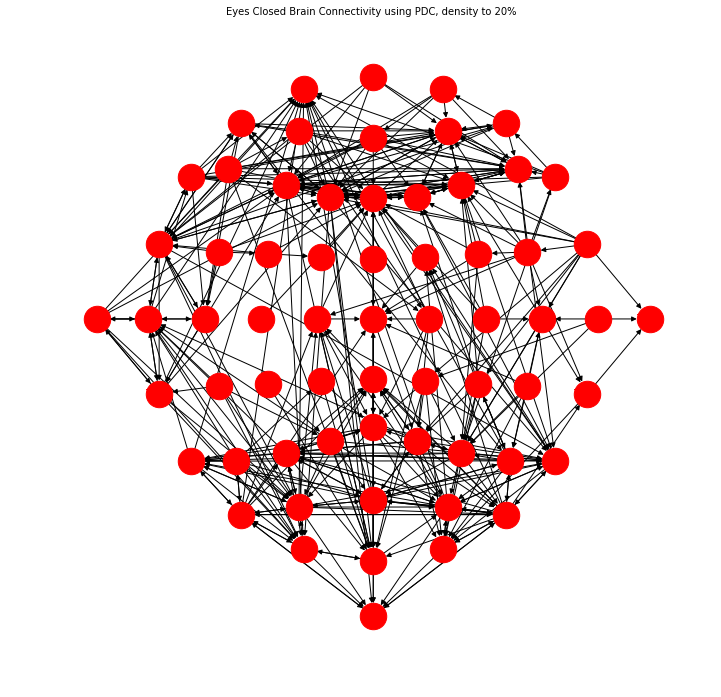

In [8]:
position = pd.read_csv('channel_locations.txt', sep='\s+')

G_close = nx.DiGraph(ec_adj)
#rename labels

G_close = nx.relabel_nodes(G_close,labels) 
#create a pos dictionary to pass the position to the nodes of our graph

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111)
ax.set_title('Eyes Closed Brain Connectivity using PDC, density to 20% ', fontsize=10)

nx.draw(G_close, pos, node_size=700)
nx.draw_networkx_labels(G_close, pos=pos, font_color='red')
#nx.draw(G_open, with_labels=True)

plt.savefig("PDC_eyes_closed.png", format="PNG")
plt.show()

3.1 Perform motifs analysis to investigate the presence of 3-node configurations in
the networks: determine their frequency and statistical significance (motifs, anti-motifs).

In [9]:
#Converting the graphs from networkx to igraph format via adj matrix, in order to perform motif analysis
IG_open = ig.Graph.Adjacency(eo_adj.tolist())
#print(IG_open)
#ed_open = IG_open.
IG_closed = ig.Graph.Adjacency(ec_adj.tolist())
#print(IG_closed)
#new adj matrix from igraph:
ieo_adj = IG_open.get_adjacency()
iec_adj = IG_closed.get_adjacency()

#checking the match of dimensions
eo_adj.shape == ieo_adj.shape
print(ieo_adj.shape)
print(iec_adj.shape)

#checking if the two adjacency matrix are equivalent 
# eyes open
for i in range (0,64):
    for j in range (0,64):
        eo_adj[i][j] == ieo_adj[i][j]

# eyes closed
for i in range (0,64):
    for j in range (0,64):
        eo_adj[i][j] == ieo_adj[i][j]

(64, 64)
(64, 64)


In [10]:
# via the method Triad census, performed on the algorithm defined by Davis and Leinhardt, we attempt to
# classify every triple of vertices in the directed graphs. Which means calculating how many times each isomorphism of
# three nodes occurs in the network. The output is a vector containing that count for any of the 16 possible states 
# of the triad in the order showed in the report. 
m_count_Open = {}
m_count_Closed = {}
# MINIMUM FREQUENCY cutoff: U = 'uniqueness threshold'
U = 4
for i in range(0,16):
    if IG_open.triad_census()[i] > U:
        m_count_Open[i] = IG_open.triad_census()[i] 
    else :
         m_count_Open[i] = 0
    if   IG_closed.triad_census()[i] > U:
        m_count_Closed[i] = IG_closed.triad_census()[i]
    else :
        m_count_Closed[i] = 0

#m_count_Open = (m_count_Open > 4).astype(int)
#print(m_count_Open)
#print(m_count_Closed)

In [11]:
g_rand = {}
triad_rands = {}
triad_mean = {}
triad_sd = {}
z_open = {}
z_closed = {}
prob_treshold_open = {}
prob1_treshold_open = {}

prob_treshold_closed = {}
prob2_treshold_closed = {}
check_p_open = {}
check1_p_open = {}
check2_p_closed = {}

check_p_closed = {}
mdev_open = {}
mdev_closed = {}

x = 0
p = 0.01 #probability set to 1%
D = 0.10 # minimum deviation parameter 

# Generating N = 1000 different random graphs with the 'Erdos_Renyi' method 
for i in range (0,1000):
    g_rand[i] = ig.Graph.Erdos_Renyi(n=64, m=404, directed=True, loops=False)
    triad_rands[i] = g_rand[i].triad_census()

# OVER REPRESENTATION check. 
# The probability of finding a motif in a randomized graph a number of times greater or equal than in the real network 
# must be lower than a cutoff value p = 0.01; Determined on the set of 1000 randomized networks 

for j in range(0,16):
        x = 0
        for k in range(0,1000):
            if (triad_rands[k][j] > m_count_Open[j]):
                x += 1 
        prob_treshold_open[j] = x/1000
        if prob_treshold_open[j] < p:
            check_p_open[j] = 'OK'
        else:
            check_p_open[j] = 'NO'
for j in range(0,16):
        x = 0
        for k in range(0,1000):
            if (triad_rands[k][j] > m_count_Closed[j]):
                x += 1 
        prob_treshold_closed[j] = x/1000
        if prob_treshold_closed[j] < p:
            check_p_closed[j] = 'OK'
        else:
            check_p_closed[j] = 'NO'
            
for j in range(0,16):
        x = 0
        for k in range(0,1000):
            if (triad_rands[k][j] < m_count_Open[j]):
                x += 1 
        prob1_treshold_open[j] = x/1000
        if prob1_treshold_open[j] < p:
            check1_p_open[j] = 'OK'
        else:
            check1_p_open[j] = 'NO'
for j in range(0,16):
        x = 0
        for k in range(0,1000):
            if (triad_rands[k][j] < m_count_Closed[j]):
                x += 1 
        prob2_treshold_closed[j] = x/1000
        if prob2_treshold_closed[j] < p:
            check2_p_closed[j] = 'OK'
        else:
            check2_p_closed[j] = 'NO'
#print(check_p_open
#print(prob_treshold)
random_nets = pd.DataFrame(triad_rands)
triad_mean = random_nets.mean(axis=1)
triad_sd = random_nets.std(axis=1)

# MINIMUM DEVIATION check. 
for j in range (0,16):
    if ((m_count_Open[j]-triad_mean[j]) > D * triad_mean[j]):
        mdev_open[j] = 'OK'
    if ((m_count_Closed[j]-triad_mean[j]) > D * triad_mean[j]):
        mdev_closed[j] = 'OK'

# Assigning Z-score 
for j in range (0,16):
    z_open[j] = np.abs((m_count_Open[j]-triad_mean[j])/triad_sd[j])
    z_closed[j] = np.abs((m_count_Closed[j]-triad_mean[j])/triad_sd[j])



    
Outputs_open = pd.DataFrame.from_dict(m_count_Open, orient = 'index', columns = ['Motif Occurrance'])
triad_mean = pd.DataFrame(triad_mean, columns = ['Random Occurrance'])
triad_sd = pd.DataFrame(triad_sd, columns = ['+- SD'])
z_open = pd.DataFrame.from_dict(z_open, orient = 'index', columns = ['Z Score'])
prob_treshold_open = pd.DataFrame.from_dict(prob_treshold_open, orient = 'index', columns = ['P'])
check_p_open = pd.DataFrame.from_dict(check_p_open, orient = 'index', columns = ['Candidate'])
mdev_open =  pd.DataFrame.from_dict(mdev_open, orient = 'index', columns = ['Candidate'])
ap = pd.concat([Outputs_open,triad_mean,triad_sd, z_open,mdev_open, check_p_open], axis = 1)
ap = ap.round()
ap = ap.transpose()
ap

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Motif Occurrance,23463,12571,834,2053,1087,642,217,34,577,0,14,115,25,16,12,0
Random Occurrance,22100,14795,818,823,823,1646,182,181,183,61,10,10,10,20,2,0
+- SD,166,263,167,43,44,79,35,35,18,9,5,3,3,6,2,0
Z Score,8,8,0,29,6,13,1,4,22,7,1,30,4,1,6,0
Candidate,NaN,NaN,NaN,OK,OK,NaN,OK,NaN,OK,NaN,OK,OK,OK,NaN,OK,NaN
Candidate,OK,NO,NO,OK,OK,NO,NO,NO,OK,NO,NO,OK,OK,NO,OK,NO


In [12]:
Outputs_closed = pd.DataFrame.from_dict(m_count_Closed, orient = 'index', columns = ['Motif Occurrence'])
z_closed = pd.DataFrame.from_dict(z_closed, orient = 'index', columns = ['Z Score'])
prob_treshold_closed = pd.DataFrame.from_dict(prob_treshold_closed, orient = 'index', columns = ['P'])
check_p_closed = pd.DataFrame.from_dict(check_p_closed, orient = 'index', columns = ['Candidate'])
mdev_closed =  pd.DataFrame.from_dict(mdev_closed, orient = 'index', columns = ['Candidate'])
pc = pd.concat([Outputs_closed,triad_mean,triad_sd, z_closed, prob_treshold_closed, check_p_closed,mdev_closed], axis = 1)
pc = pc.round()
pc = pc.transpose()
pc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Motif Occurrence,24015,12103,2362,365,790,731,422,213,238,8,44,146,95,33,60,39
Random Occurrance,22100,14795,818,823,823,1646,182,181,183,61,10,10,10,20,2,0
+- SD,166,263,167,43,44,79,35,35,18,9,5,3,3,6,2,0
Z Score,12,10,9,11,1,12,7,1,3,6,7,39,25,2,34,186
P,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0
Candidate,OK,NO,OK,NO,NO,NO,OK,NO,OK,NO,OK,OK,OK,NO,OK,OK
Candidate,NaN,NaN,OK,NaN,NaN,NaN,OK,OK,OK,NaN,OK,OK,OK,OK,OK,OK


In [13]:
Com = IG_open.community_infomap()
Com1 = IG_closed.community_infomap()


In [14]:
print(Com)
print(Com1)

Clustering with 64 elements and 4 clusters
[0] 0, 7, 11, 14, 15, 21, 24, 30, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 54,
    55, 56, 58, 59, 60, 61, 62, 63
[1] 4, 5, 17, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37
[2] 1, 2, 3, 8, 9, 16, 50, 57
[3] 6, 10, 12, 13, 18, 19, 20, 39, 41, 51, 52, 53
Clustering with 64 elements and 3 clusters
[0] 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 39, 41, 43,
    45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63
[1] 2, 8, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37
[2] 0, 1, 7, 29, 38, 40, 42, 44


In [15]:
Com1 = IG_open.as_undirected()

In [16]:
Com1 = Com1.community_leading_eigenvector()

In [17]:
print(Com1)

Clustering with 64 elements and 4 clusters
[0] 0, 9, 12, 15, 16, 18, 19, 20, 48, 50, 51, 52, 53, 54, 57
[1] 1, 2, 3, 8, 10, 11, 17, 24, 30, 33, 38, 61
[2] 7, 14, 21, 40, 42, 43, 44, 45, 46, 47, 49, 55, 56, 58, 59, 60, 62, 63
[3] 4, 5, 6, 13, 22, 23, 25, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 39, 41


In [18]:
motif = ig.Graph.Adjacency([[0,1,0],[0,0,0],[0,1,0]])
print(motif)

IGRAPH D--- 3 2 --
+ edges:
0->1 2->1


In [19]:
#motif_graph = IG_open.subisomorphic_vf2(motif, color1 = c1)
#ig.Graph.subgraph_edge
print(IG_open)

IGRAPH D--- 64 404 --
+ edges:
 0 ->  1  9 12 33 38 42 48 53
 1 ->  2  9 33
 2 ->  9 33
 3 -> 33 50
 4 -> 27 33 36 50
 5 ->  4 27 33 36 52
 6 ->  5 13 19 27 31 32 36 37 52
 7 ->  9 33 42 44 48
 8 ->  2  9 17 33 44 50
 9 -> 33 50 61
10 -> 33 50 51 61
11 -> 33 50 51 61
12 -> 13 52
13 -> 27 31 32 36 37 52 53
14 ->  7 42 44 48 56
15 -> 48 50 56
16 -> 50 61
17 -> 19 50 51 61
18 -> 50 51 52 61
19 -> 51 52 53 58 61 62
20 -> 13 19 52 53 58 62
21 ->
22 -> 23 27 31 32 36
23 -> 27 31 32 36
24 ->  4  7 17 19 23 27 28 36 38 44 54 58 59 61 62
25 ->  4  7 17 27 31 32 33 36 38 58 62
26 -> 17 27 31 32 33 36
27 -> 31 32 36
28 -> 23 27 32 36
29 -> 17 22 25 27 31 32 36 38 44 56 62
30 ->  1  2  3  4  7  9 10 11 15 16 17 18 22 24 25 26 27 31 32 33 36 37 38 40
44 48 51 54 55 58 61 62 63
31 -> 17 32 33 50 61
32 -> 17 31 33 36 50 61
33 -> 17 26 27 31 32 36 50 61
34 -> 17 27 31 32 33 36
35 -> 17 27 31 32 33 36
36 -> 17 27 31 32
37 -> 27 28 36
38 ->  2 17 22 31 32 42 44 54 55 56 58
39 ->  6 13 43
40 ->  7 16 22 

In [23]:
SUB = IG_open.subgraph([0,13,20,49,45,48,51,52,54,58,59])
print(SUB)
TRIAD = SUB.triad_census()
TRIAD

IGRAPH D--- 11 38 --
+ edges:
 0 ->  4                               6 ->  4  7  8  9
 1 ->  7                               7 ->  4  6  8  9
 2 ->  1  7  9                         8 ->  3  9 10
 3 ->  9 10                            9 ->  4  8 10
 4 ->  8  9 10                        10 ->  3  4  8  9
 5 ->  0  1  2  3  4  6  7  8  9 10


TriadCensus((19, 34, 18, 25, 6, 9, 14, 0, 18, 0, 1, 11, 3, 1, 4, 2))